# Outline of the Notebook

# Part I: Codes
## We import useful libraries and define functions for modeling inversion and regularization

# Part II: Applications (as seen in our article)
## Example 1: plasma wave equation 
## Example 2: acoustic wave equation with variable denisty 

# Part I

# Import libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
import scipy as sp
import scipy.sparse as sps
from scipy import interpolate
from scipy.sparse.linalg import lsqr
from scipy import fft,ifft
from scipy.optimize import minimize_scalar, minimize

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


# Functions for generating scattering data 

In [3]:
#The following wave solver is used in Example 1 (PLASMA WAVE EQUATION)
def SolveWE(q,f,T,L,h):
    """
    Solve plasma wave-equation 
    
        u_tt(t,x) = u_xx(t,x) - q(x) u(t,x) + f(t,x) on [0,T] x [0,L]
    
    Uses second-order FD scheme with absorbing boundary conditions
    
    input:
        q - scattering potential q(x) (callable)
        f - source function f(t,x) (callable)
        T,L - domain (floats)
        h - gridsize (float)
        
    output:
        t - temporal grid (1d array)
        x - spatial grid (1d array)
        u - solution (2d array)
    """
    
    Nt = int(round(T/h))
    t = np.linspace(0, Nt*h, Nt+1)   
    Nx = int(round(L/h))
    x = np.linspace(0, Nx*h, Nx+1) 
    
    u  = np.zeros((Nt+1,Nx+1)) 
    
    for n in range(1,Nt):
        u[n+1,0] = ( u[n,0] + (u[n,1] - u[n,0]) )
        u[n+1,1:-1] = -u[n-1,1:-1] + 2*u[n,1:-1] + (u[n,2:] - 2*u[n,1:-1] + u[n,0:-2]) + h**2*(-q(x[1:-1])*u[n,1:-1] + f(t[n],x[1:-1]))
        u[n+1,Nx] = ( u[n,Nx] + (u[n,Nx-1] - u[n,Nx]) )
        
    return t,x,u

# The following is used in Example 2 (ACOUSTIC WAVE EQUATION WITH VARIABLE DENSITY)
def SolveWE2(rho,f,T,L,dx):
    
    Le = 2.1*T
    
    nx = int(2*Le/dx - 1)
    dt = 0.8*h
    nt = int(T/dt)
    
    x = np.linspace(-Le+dx,Le-dx,nx)
    xm = np.linspace(-Le+dx/2,Le-dx/2,nx+1)
    t = np.linspace(0,T,nt)
    
    mu = rho(xm)
    A = sps.diags(1/rho(x),0)
    D = sps.diags([-np.ones(nx), np.ones(nx)],[-1,0],shape=(nx+1,nx))/dx
    M = sps.diags([mu],[0])
    I = sps.identity(nx)
    B = -D.T@M@D
    
    u = np.zeros((nt,nx))
    for k in range(2,nt-1):
        u[k+1] = (2*I + (dt**2)*A@B)@u[k] - u[k-1] + (dt**2)*A@f((k+1)*dt,x)
        
    a = nx//2
    b = np.where(x>L)[0][0]
    return t,x[a:b],u[:,a:b]

def H(x,f0):
    # smooth Heaviside
    return 0.5 + 0.5*sp.special.erf(np.pi*f0*x)

def delta(x,f0):
    # smooth approximation of \delta(x)
    return f0*np.sqrt(np.pi)*np.exp(-(np.pi*f0*x)**2)

def deltap(x,f0):
    # smooth approximation of \delta'(x)
    epsilon = 0.5/(np.pi*f0)**2
    return f0*np.sqrt(np.pi)*(-2*x*(np.pi*f0)**2)*np.exp(-(np.pi*f0*x)**2)

def getScatteringData(q,T,L,h,x0,t0,f0):
    """
    Generate scattering data by solving the wave-equation with source term
        
        f(t,x) = \delta(x-x0)\delta'(t-t0)
    
    input:
        q,T,h - paramters for SolveWE
        x0,t0,f0 - source parameters
        
    output:
        x - spatial grid (1d array)
        t - temporal grid (1d array)
        r - scattering data (1d array)
    """
    # source
    f = lambda t,x : delta(x-x0,f0)*deltap(t-t0,f0)
    
    # solve wave-equation
    t,x,u = SolveWE(q,f,T,L,h)
    t,x,u0 = SolveWE(lambda x : 0*x,f,T,L,h)
    
    # interpolate scattering data
    r = interpolate.interp1d(x,u - u0,axis=1)(x0)
    
    return x,t,r

def getScatteringData2(rho,T,L,h,x0,t0,f0):
    """
    Generate scattering data by solving the wave-equation with source term
        
        f(t,x) = \delta(x-x0)\delta'(t-t0)
    
    input:
        rho,T,h - paramters for SolveWE2
        x0,t0,f0 - source parameters
        
    output:
        x - spatial grid (1d array)
        t - temporal grid (1d array)
        r - scattering data (1d array)
    """
    # source
    f = lambda t,x : delta(x-x0,f0)*deltap(t-t0,f0)
    
    # solve wave-equation
    t,x,u = SolveWE2(rho,f,T,L,h)
    t,x,u0 = SolveWE2(lambda x : 0*x + 1,f,T,L,h)
    
    # interpolate scattering data
    r = interpolate.interp1d(x,u - u0,axis=1)(x0)
    
    return x,t,r,u,u0

# Tikhonov/Least squares function definition

In [4]:
def Solve_GLM_LS(r,t,alpha=1e-16):
    """
    Solve the GLM equation: 
        
        r(x + y) + \int_0^T B(x,z)r(x + y + z)dz + B(x,y) = 0
    
    for B(x,z) by posing it as a regularised least-squares problem
    
        min_b \|A_x b + r_x\|_2^2 + \alpha \|L b\|_2^2,
        
    with L the second derivative operator.
    
    input:
        r - scattering data (1d array)
        t - temporal grid at which r is given (1d array)
        alpha - regularization parameter (float), default=1e-16
        method - {'tsvd','lsqr'}, default='lsqr'
    
    output:
        B - solution (2d array)
        t - temporal grid at which B is defined (1d array)
        phi - value of objective
    """
    # grid
    nt = len(t)
    dt = t[2]-t[1]
    mt = int(nt/3)
    
    # Regularisation operator
    L = sps.spdiags(np.outer(np.array([1,-2,1]),np.ones(mt)),np.array([-1,0,1]),mt,mt).toarray()
    
    # initialize
    B = np.zeros((mt,mt))
    phi = 0
    
    # solve for every column
    for j in range(mt):
        # generate operator (Hankel matrix)
        I = np.identity(mt)
        R = la.hankel(r[j:j+mt],r[j+mt-1:j+2*mt-1])
        A = I + dt*R
        B[:,j] = lsqr(np.concatenate((A,np.sqrt(alpha)*L)),np.concatenate((-r[j:j+mt],np.zeros(mt))))[0]
        phi += np.linalg.norm(B[:,j] + dt*R@B[:,j] + r[j:j+mt])**2 + alpha*np.linalg.norm(L@B[:,j])**2
    return B,t[:mt],phi

# Total least squares function

In [22]:
def Solve_GLM_TLS(r,t,alpha=[1e-16,1e-3],maxit=(10,10)):
    """
    Solve the GLM equation: 
        
        (r + e)(x + y) + \int_0^T B(x,z)(r + e)(x + y + z)dz + B(x,y) = 0.
    
    for e and B in a Total Least-Squares sense using altermating minimisation.
    
    input:
        r - scattering data (1d array)
        t - temporal grid at which r is given (1d array)
        alpha - regularization parameters for \|B\|^2 and \|e\|^2  (float, float), default=(1e-16,1e-3)
        maxit - maximum (inner,outer) iterations (int,int), default=(10,10)
    
    output:
        B - estimated kernel (2d array)
        e - estimated error
        t - temporal grid at which B is defined (1d array)
        hist - objective at each iteration (1d array)
    """
    
    # grid
    nt = len(t)
    dt = t[2]-t[1]
    mt = int(nt/3)
    
    # initialize
    B = np.zeros((mt,mt))
    e = np.zeros(nt)
    hist = np.zeros(maxit[1])
    
    # Regularisation operator
    L = sps.spdiags(np.outer(np.array([1,-2,1]),np.ones(mt)),np.array([-1,0,1]),mt,mt).toarray()
    
    # main loop
    for it in range(maxit[1]):
        # estimate kernel
        B,ts,phi= Solve_GLM_LS(r + e,t,alpha[0])
        
        # estimate error
        
        ## first, setup system of m^2 x n equations for e
        A = np.zeros((mt**2,nt))
        b = np.zeros(mt**2)
        k = 0
        for i in range(mt):
            for j in range(mt):
                A[k,i+j] = 1
                A[k,i+j:i+j+mt] += dt*B[:,i]
                b[k] = -(r[i + j] + dt*B[:,i].dot(r[i+j:i+j+mt]) + B[j,i])             
                k += 1
        ## now solve it
        e = lsqr(A,b,damp=np.sqrt(alpha[1]),iter_lim=maxit[0])[0]
        
        ## objective
        hist[it] = phi + alpha[1]*np.linalg.norm(e)**2
    return B,e,t[:mt],hist

In [16]:
def reconstruct(B,ts,t0,x0):
    """
    Reconstruct scattering potential from Kernel
    """
    ns = len(ts)-2
    xs = ts[1:-1]/2-(t0/2-x0)
    h = (xs[1] - xs[0])
    
    q_hat = 2*(B[0,2:] - B[0,:-2])/(h)
    return q_hat, xs

# Part II

# Example 1

# Generate scattering data

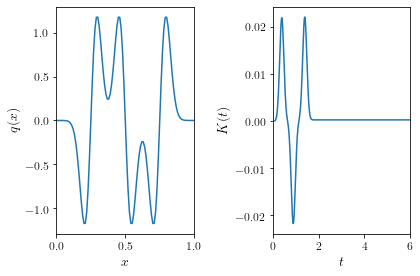

In [80]:
# domain and grid: t \in [0,T], x \in [0,L]
T = 6
L = 1
h = 0.01

# parameters: t0 - time offset, x0 - spatial offset, f0 - central frequency
t0 = .1
x0 = .1
f0 = 10

# velocity and density
c = lambda x : 1 + 0*x
rho = lambda x : 1 - 1e-2*H(x-.25,f0/2) + 1e-2*H(x-.5,f0/2) - 1e-2*H(x-.75,f0/2)

# scattering potential
q = lambda x : ((rho(x+h) - 2*rho(x) + rho(x-h))/h**2)/np.sqrt(rho(x))

# get scattering data
x,t,r = getScatteringData(q,T,L,h,x0,t0,2*f0)

# plot
fig,ax = plt.subplots(1,2)

ax[0].plot(x,q(x))
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$q(x)$')
ax[0].set_xlim([0,L])

ax[1].plot(t,r)
ax[1].set_xlim([0,T])
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$K(t)$')

fig.tight_layout()
plt.savefig("example1_data.pdf",dpi=600)

# Solve noise-free problem

In [81]:
%%time
B_hat,ts,phi = Solve_GLM_LS(r,t,alpha=1e-16)
q_hat, xs = reconstruct(B_hat,ts,t0,x0)

CPU times: user 940 ms, sys: 338 ms, total: 1.28 s
Wall time: 232 ms


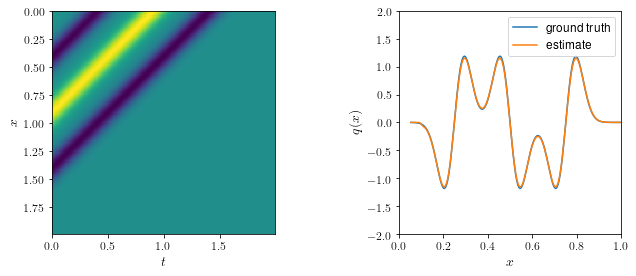

In [82]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(B_hat,extent=[0,ts[-1],ts[-1],0])
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$x$')
#ax[0].set_title('GLM kernel')

ax[1].plot(xs,q(xs),label='ground truth')
ax[1].plot(xs,q_hat,label='estimate')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$q(x)$')
ax[1].set_xlim([0,L])
ax[1].set_ylim([-2,2])
ax[1].set_aspect(.25)
ax[1].legend(loc='upper right')
#ax[1].set_title('potentials')

fig.set_figwidth(10)
fig.tight_layout()
plt.savefig("example1_clean.pdf",dpi=600)

# Noisy data

In [86]:
def noisy_reconstruction(sigma, fname):
    # noisy data
    r_delta = r + sigma*np.random.randn(len(r))
    
    # reference solution
    B0,ts,phi = Solve_GLM_LS(r,t,alpha=1e-16)
    q0, xs = reconstruct(B0,ts,t0,x0)
    
    # optimal parameter LS
    def Jerror_LS(alpha):
        B_LS,tsz,phi = Solve_GLM_LS(r_delta,t,alpha=alpha)
        return np.linalg.norm(B_LS - B0,ord='fro')/np.linalg.norm(B0,ord='fro')

    result_LS = minimize_scalar(Jerror_LS, bounds=(1e-16,1e2), method='bounded')
    alpha_LS = result_LS.x
    
    # optimal parameter TLS
    def Jerror_TLS(alpha):
        B_TLS,ts,ek,res = Solve_GLM_TLS(r_delta,t,alpha=(alpha,1e-16))
        return np.linalg.norm(B_TLS - B0,ord='fro')/np.linalg.norm(B0,ord='fro')
    
    result_TLS = minimize_scalar(Jerror_TLS, bounds=(1e-16,1e2), method='bounded')
    alpha_TLS = result_TLS.x
    
    # unregularised reconstruction
    B_hat,ts,phi = Solve_GLM_LS(r_delta,t,alpha=1e-6)
    q_hat, xs    = reconstruct(B_hat,ts,t0,x0)

    # LS solution
    B_ls,ts,phi= Solve_GLM_LS(r_delta,t,alpha=alpha_LS)
    q_ls, xs = reconstruct(B_ls,ts,t0,x0)

    # TLS
    B_tls,e_tls,ts,hist = Solve_GLM_TLS(r_delta,t,alpha=(alpha_TLS,1e-16))
    q_tls, xs = reconstruct(B_tls,ts,t0,x0)
    
    # summary plot
    fig,ax = plt.subplots(2,3)

    ax[0,0].imshow(B_hat,extent=[0,ts[-1],ts[-1],0])
    ax[0,0].set_xlabel('$t$')
    ax[0,0].set_ylabel('$x$')

    ax[0,1].imshow(B_ls,extent=[0,ts[-1],ts[-1],0])
    ax[0,1].set_xlabel('$t$')
    ax[0,1].set_ylabel('$x$')

    ax[0,2].imshow(B_tls,extent=[0,ts[-1],ts[-1],0])
    ax[0,2].set_xlabel('$t$')
    ax[0,2].set_ylabel('$x$')

    ax[1,0].plot(xs,q(xs),label='ground truth')
    ax[1,0].plot(xs,q_hat,label='estimate')
    ax[1,0].set_xlabel('$x$')
    ax[1,0].set_ylabel('$q(x)$')
    ax[1,0].set_xlim([0,L])
    ax[1,0].set_ylim([-2,2])

    ax[1,1].plot(xs,q(xs),label='ground truth')
    ax[1,1].plot(xs,q_ls,label='estimate')
    ax[1,1].set_xlabel('$x$')
    ax[1,1].set_ylabel('$q(x)$')
    ax[1,1].set_xlim([0,L])
    ax[1,1].set_ylim([-2,2])

    ax[1,2].plot(xs,q(xs),label='ground truth')
    ax[1,2].plot(xs,q_tls,label='estimate')
    ax[1,2].set_xlabel('$x$')
    ax[1,2].set_ylabel('$q(x)$')
    ax[1,2].set_xlim([0,L])
    ax[1,2].set_ylim([-2,2])

    fig.tight_layout()
    plt.savefig(fname,dpi=600)
    
    # table
    # summary table
    error     = np.linalg.norm(q_hat - q0)/np.linalg.norm(q0)
    error_LS  = np.linalg.norm(q_ls - q0)/np.linalg.norm(q0)
    error_TLS = np.linalg.norm(q_tls - q0)/np.linalg.norm(q0)

    print('sigma    | error unreg | alpha    | error LS | alpha    | error TLS')
    print('%06.2e | %06.2e    | %06.2e | %06.2e | %06.2e | %06.2e' % (sigma, error,alpha_LS, error_LS, alpha_TLS, error_TLS))

sigma    | error unreg | alpha    | error LS | alpha    | error TLS
1.00e-02 | 7.62e+00    | 6.27e+02 | 8.89e-01 | 2.94e+01 | 7.52e-01


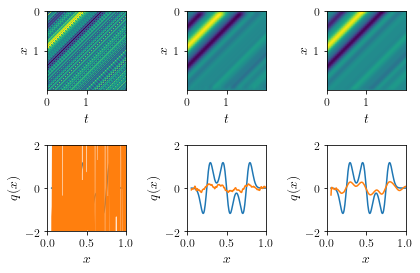

In [84]:
noisy_reconstruction(1e-2, "example1_noisy_1e-2.pdf")

sigma    | error unreg | alpha    | error LS | alpha    | error TLS
1.00e-03 | 9.09e-01    | 1.33e+00 | 4.93e-01 | 2.70e-01 | 2.83e-01


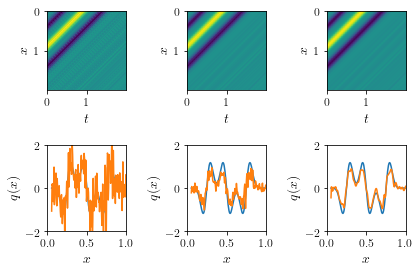

In [88]:
noisy_reconstruction(1e-3, "example1_noisy_1e-3.pdf")

sigma    | error unreg | alpha    | error LS | alpha    | error TLS
1.00e-04 | 9.30e-02    | 1.99e-02 | 9.30e-02 | 1.68e-02 | 6.48e-02


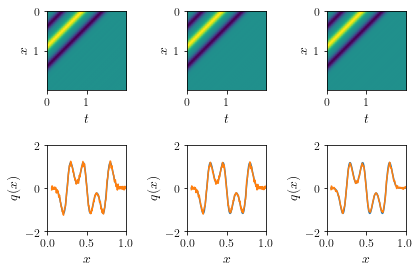

In [87]:
noisy_reconstruction(1e-4, "example1_noisy_1e-4.pdf")